<a href="https://colab.research.google.com/github/kimbob123/SNU_FinTech/blob/main/(2)_%EB%AC%B4%EC%A7%80%EC%84%B1_LSTM_%EA%B9%83%ED%97%88%EB%B8%8C%EC%9C%A0%EB%8F%99%EA%B5%AD_%EC%B0%B8%EA%B3%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#시작

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [ ]:
import pkg_resources

# 확인할 패키지 리스트
packages_to_check = [
    "datasets",
    "ipykernel",
    "ipython",
    "numpy",
    "pandas",
    "pytz",
    "torch",
    "torchaudio",
    "torchtext",
    "torchvision",
    "tqdm"
]

# 설치된 패키지의 이름과 버전 출력
installed_packages = pkg_resources.working_set
for package in installed_packages:
    if package.project_name in packages_to_check:
        print(f"{package.project_name}=={package.version}")


ipykernel==5.5.6
ipython==7.34.0
numpy==1.25.2
pandas==2.0.3
pytz==2023.4
torch==2.3.0+cu121
torchaudio==2.3.0+cu121
torchtext==0.18.0
torchvision==0.18.0+cu121
tqdm==4.66.4


In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#전처리

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3 non-null      int64 
 1   prompt      3 non-null      object
 2   response_a  3 non-null      object
 3   response_b  3 non-null      object
dtypes: int64(1), object(3)
memory usage: 224.0+ bytes


In [ ]:
test_data

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/챗봇 답변 선호/train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [ ]:
train_data

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [ ]:
def assign_label(row):
    if row['winner_tie'] == 1:
        return 1, 1, row['response_a'], row['response_b']
    elif row['winner_model_a'] == 1:
        return 2, 0, row['response_a'], row['response_b']
    elif row['winner_model_b'] == 1:
        return 0, 2, row['response_a'], row['response_b']

# 'assign_label' 함수를 적용하여 'label'과 'response' 열 생성
train_data['label_a'], train_data['label_b'], train_data['response_a'], train_data['response_b'] = zip(*train_data.apply(assign_label, axis=1))

# 필요한 열만 선택 후 id와 response_a, response_b를 다루어 새로운 데이터프레임 생성
response_a_df = train_data[['id', 'response_a', 'label_a']].rename(columns={'response_a': 'response', 'label_a': 'label'})
response_b_df = train_data[['id', 'response_b', 'label_b']].rename(columns={'response_b': 'response', 'label_b': 'label'})
train_data = pd.concat([response_a_df, response_b_df], ignore_index=True)
train_data


,id,response,label
0,30192,"[""The question of whether it is morally right ...",2
1,53567,"[""A marriage license is a legal document that ...",0
2,65089,"[""Function calling is the process of invoking ...",1
3,96401,"[""Creating a test set for a very rare category...",2
4,198779,"[""The best way to travel from Tel Aviv to Jeru...",0
...,...,...,...
114949,4294656694,"[""Here is how that mnemonic represents the dig...",0
114950,4294692063,"[""Sure! Here's an implementation of a naive Ba...",0
114951,4294710549,"[""It depends on the context. Weapons can be us...",0
114952,4294899228,"[""As an AI language model, I do not promote or...",2


## 토큰화

In [ ]:
train_data

,id,response,label
0,30192,"[""The question of whether it is morally right ...",2
1,53567,"[""A marriage license is a legal document that ...",0
2,65089,"[""Function calling is the process of invoking ...",1
3,96401,"[""Creating a test set for a very rare category...",2
4,198779,"[""The best way to travel from Tel Aviv to Jeru...",0
...,...,...,...
114949,4294656694,"[""Here is how that mnemonic represents the dig...",0
114950,4294692063,"[""Sure! Here's an implementation of a naive Ba...",0
114951,4294710549,"[""It depends on the context. Weapons can be us...",0
114952,4294899228,"[""As an AI language model, I do not promote or...",2


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114954 entries, 0 to 114953
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        114954 non-null  int64 
 1   response  114954 non-null  object
 2   label     114954 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.6+ MB


In [ ]:
train_data = datasets.Dataset.from_pandas(train_data)

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["response"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}



max_length = 500

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

Map:   0%|          | 0/114954 [00:00<?, ? examples/s]

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
len(train_data), len(valid_data)

(86215, 28739)

## Vocab 만들기

In [ ]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]
from torchtext.vocab import Vocab
vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [ ]:
len(vocab)

80795

In [ ]:
vocab.get_itos()[:10]


['<unk>', '<pad>', '.', ',', 'the', 'and', 'to', 'a', 'of', 'in']

In [ ]:
vocab["and"]

5

In [ ]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

## 숫자화

In [ ]:
vocab.set_default_index(unk_index) #이거 없으면 numericalize 안돌아감 ;;

In [ ]:
#여기서 글자를 숫자로 만드는구나...
def numericalize(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [ ]:
train_data = train_data.map(numericalize, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize, fn_kwargs={"vocab": vocab})

Map:   0%|          | 0/86215 [00:00<?, ? examples/s]

Map:   0%|          | 0/28739 [00:00<?, ? examples/s]

## 토치화

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", 'length'])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", 'length'])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)

In [ ]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

.vector_cache/glove.840B.300d.zip: 2.18GB [07:00, 5.18MB/s]                            
100%|█████████▉| 2196016/2196017 [04:00<00:00, 9122.72it/s]


# 모델! LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, length, batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 128
output_dim = len(train_data.unique("label"))
n_layers = 4
bidirectional = True
dropout_rate = 0.2

lstm_model = LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    bidirectional,
    dropout_rate,
    pad_index,
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(lstm_model):,} trainable parameters")

The model has 25,865,383 trainable parameters


In [ ]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                nn.init.orthogonal_(param)

In [ ]:
lstm_model.apply(initialize_weights)

LSTM(
  (embedding): Embedding(80795, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
lstm_model.embedding.weight.data = pretrained_embedding

In [ ]:
lr = 5e-4

optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
# cuda 사용함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
lstm_model = lstm_model.to(device)
criterion = criterion.to(device)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(dataloader, desc="training..."):
        ids = batch["ids"].to(device)
        length = batch["length"]
        label = batch["label"].to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            length = batch["length"]
            label = batch["label"].to(device)
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

#LSTM 학습 & Val 평가

In [ ]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, lstm_model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, lstm_model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(lstm_model.state_dict(), "base_lstm.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 57/57 [00:09<00:00,  5.77it/s]


epoch: 0
train_loss: 1.090, train_acc: 0.373
valid_loss: 1.083, valid_acc: 0.389


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.69it/s]


epoch: 1
train_loss: 1.076, train_acc: 0.399
valid_loss: 1.076, valid_acc: 0.404


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]


epoch: 2
train_loss: 1.043, train_acc: 0.441
valid_loss: 1.078, valid_acc: 0.403


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]


epoch: 3
train_loss: 0.971, train_acc: 0.500
valid_loss: 1.116, valid_acc: 0.409


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]


epoch: 4
train_loss: 0.878, train_acc: 0.564
valid_loss: 1.167, valid_acc: 0.399


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]


epoch: 5
train_loss: 0.793, train_acc: 0.614
valid_loss: 1.278, valid_acc: 0.395


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]


epoch: 6
train_loss: 0.707, train_acc: 0.667
valid_loss: 1.377, valid_acc: 0.394


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.66it/s]


epoch: 7
train_loss: 0.632, train_acc: 0.705
valid_loss: 1.465, valid_acc: 0.388


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.54it/s]


epoch: 8
train_loss: 0.566, train_acc: 0.740
valid_loss: 1.641, valid_acc: 0.385


evaluating...: 100%|██████████| 57/57 [00:10<00:00,  5.65it/s]

epoch: 9
train_loss: 0.507, train_acc: 0.769
valid_loss: 1.839, valid_acc: 0.389


In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

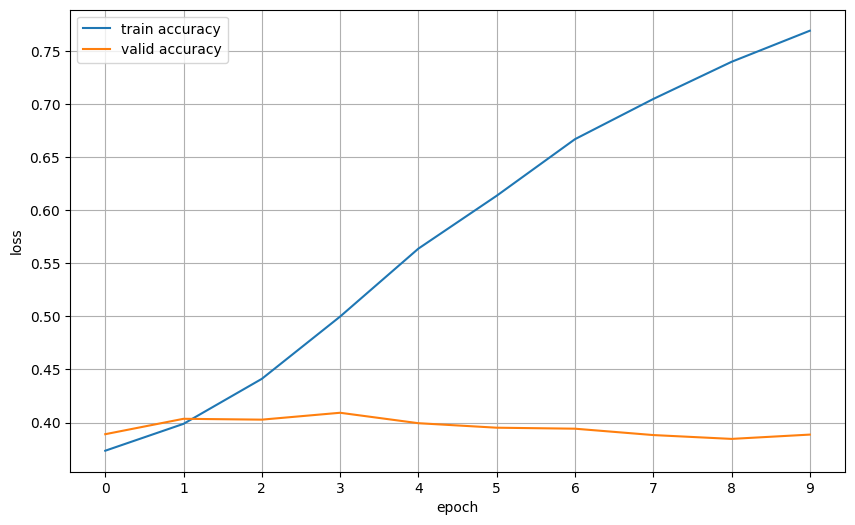

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()